In [62]:
### Alex Zhang 512910

In [115]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.graphics.gofplots as sm
from sklearn.metrics import r2_score
from statsmodels.formula.api import ols
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [64]:
# Section 1
# 1.Transform Price so that it looks more normal, 
# produce histograms of the variable before and after transformation

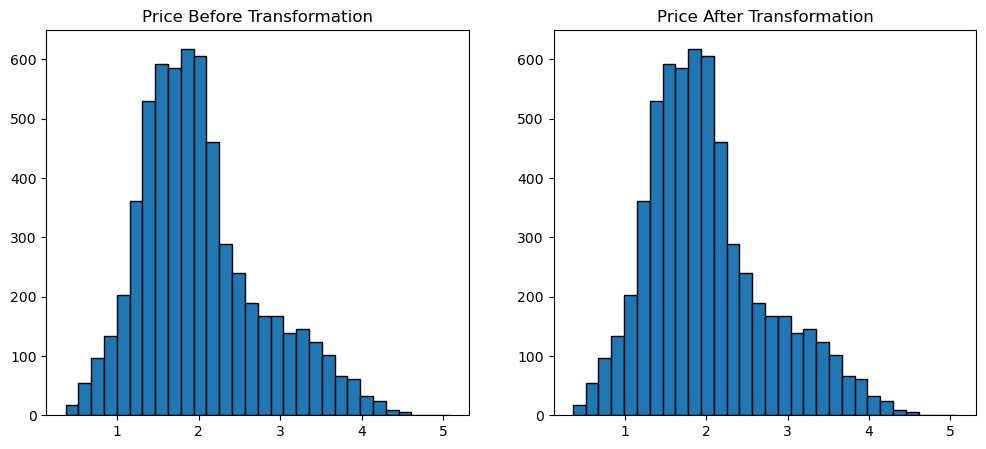

In [65]:
df1 = pd.read_csv("cars.csv")
df1["Price"] = np.log1p(df1["Price"])

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(df1["Price"], bins=30, edgecolor="k")
plt.title("Price Before Transformation")
plt.subplot(1, 2, 2)
plt.hist(df1["Price"], bins=30, edgecolor="k")
plt.title("Price After Transformation")
plt.show()

In [66]:
df1["Mileage"] = df1["Mileage"].str.rstrip(" kmpl")
df1["Mileage"] = df1["Mileage"].str.rstrip(" km/g")
df1["Engine"] = df1["Engine"].str.rstrip(" CC")
df1["Power"] = df1["Power"].str.rstrip(" bhp")
df1["Power"]= df1["Power"].replace(regex="null", value = np.nan)
df1["Fuel_Type"]=df1["Fuel_Type"].astype("category")
df1["Transmission"]=df1["Transmission"].astype("category")
df1["Owner_Type"]=df1["Owner_Type"].astype("category")
df1["Mileage"]=df1["Mileage"].astype("float")
df1["Power"]=df1["Power"].astype("float")
df1["Engine"]=df1["Engine"].astype("float")
df1["Company"]=df1["Name"].str.split(" ").str[0]
df1["Model"]=df1["Name"].str.split(" ").str[1]+df1["Name"].str.split(" ").str[2]

In [67]:
# 2. How many values are missing for Power and Engine?

In [68]:
missing_power = df1["Power"].isnull().sum()
missing_engine = df1["Engine"].isnull().sum()

print("Missing Power:", missing_power)
print("Missing Engine:", missing_engine)

Missing Power: 143
Missing Engine: 36


In [69]:
# 3. Which column has the most missing values and what should we do about it?

In [70]:
missing_values = df1.isnull().sum()
column_with_most_missing = missing_values.idxmax()

In [71]:
print("Column with Most Missing Values:",column_with_most_missing )

Column with Most Missing Values: New_Price


In [72]:
# We can drop the column entirely if the New_Price column is not vital for analysis

In [73]:
# 4. Build a model of transformed price based on Power, Mileage, Kilometers Driven, and Year, how
# much variance is explained?

In [74]:
Y = df1['Price']
lm = ols('Y ~ Power + Mileage + Kilometers_Driven + Year', data = df1).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     6699.
Date:                Wed, 25 Oct 2023   Prob (F-statistic):               0.00
Time:                        20:52:59   Log-Likelihood:                -1547.1
No. Observations:                5874   AIC:                             3104.
Df Residuals:                    5869   BIC:                             3138.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          -219.2064      2.81

In [75]:
# R-squared = 0.82. 82% of the variance is explained by the model. 

In [76]:
# 5. How many rows were used to train the model?

In [77]:
# The No. Observations = 5874 meaning that 5874 rows are used to train the model. 

In [78]:
# 6. Fill the missing values in Power and Mileage with their respective means and rebuild the model.
# Now how much variance is explained?

In [79]:
df2 = df1.copy()
df2['Power'].fillna(df1['Power'].mean(), inplace=True)
df2['Mileage'].fillna(df1['Mileage'].mean(), inplace=True)
lm = ols('Price ~ Year + Kilometers_Driven + Mileage + Power', data=df2).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     6477.
Date:                Wed, 25 Oct 2023   Prob (F-statistic):               0.00
Time:                        20:52:59   Log-Likelihood:                -1770.8
No. Observations:                6019   AIC:                             3552.
Df Residuals:                    6014   BIC:                             3585.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          -222.4176      2.819    -78.909      0.000    -227.943    -216.892
Year                  0.1110      0.001     79.005      0.000       0.108       0.114
Kilometers_Driven  9.871e-08   4.66e-08      2.117      0.034    7.32e-09     1.9e-07
Mileage              -0.0101      0.001     -8.843      0.000      -0.012      -0.008
Power                 0.0103   9.35e-05    110.121      0.000       0.010       0.010
==============================================================================
Omnibus:                     1031.448   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16101.189
Skew:                          -0.336   Prob(JB):                         0.00
Kurtosis:                      10.984   Cond. No.                     7.31e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.31e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [80]:
# 7. The No. Observations = 6019. There are 6019 rows that are used to train the model. 

In [81]:
#8. Impute the missing data using MICE and rebuild the model

In [82]:
df3 = pd.DataFrame({'Power': df1["Power"],'Mileage': df1["Mileage"], 
                    'Kilometers_Driven': df1["Kilometers_Driven"], 'Year': df1["Year"]})
                  
lr = LinearRegression()
imp = IterativeImputer(estimator=lr,missing_values=np.nan, max_iter=10, verbose=2, imputation_order='roman',random_state=0)
x = imp.fit_transform(df3)

[IterativeImputer] Completing matrix with shape (6019, 4)
[IterativeImputer] Ending imputation round 1/10, elapsed time 0.00
[IterativeImputer] Change: 128.15185963989518, scaled tolerance: 6500.0 
[IterativeImputer] Early stopping criterion reached.


In [83]:
x = sm.add_constant(x)
y = df2['Price']
model = sm.OLS(y, x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     5805.
Date:                Wed, 25 Oct 2023   Prob (F-statistic):               0.00
Time:                        20:52:59   Log-Likelihood:                -2035.3
No. Observations:                6019   AIC:                             4081.
Df Residuals:                    6014   BIC:                             4114.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -224.8651      2.943    -76.395      0.0

In [84]:
# 9. How have the parameter estimates changed from step 4?

In [85]:
# We can see that the coefficient for Power did not change, but for Mileage, Year and Kilometers Driven, 
# the standard error for these parameters all decreased. R^2 has decresed from 0.812 to 0.794.

In [86]:
#10. Plot the distribution of Power with and without MICE

Text(0.5, 1.0, 'Distribution of Power Without MICE')

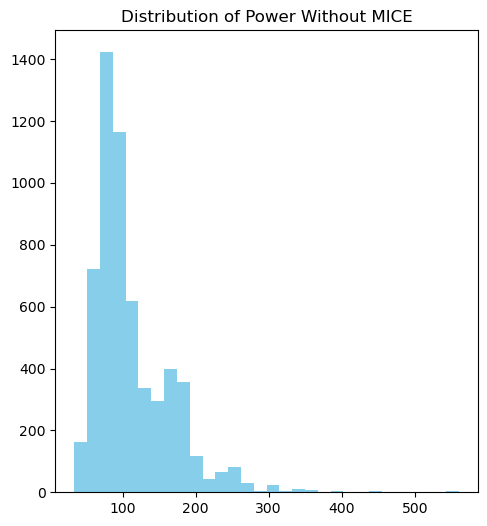

In [87]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(df1['Power'], bins=30, color='skyblue')
plt.title('Distribution of Power Without MICE')

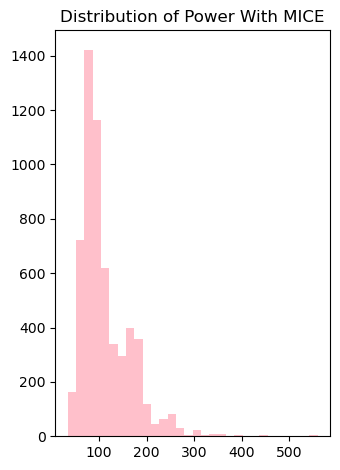

In [88]:
plt.subplot(1, 2, 2)
plt.hist(df3['Power'], bins=30, color='pink')
plt.title('Distribution of Power With MICE')

plt.tight_layout()
plt.show()

In [89]:
df4 = pd.DataFrame({'Mileage': df1["Mileage"],'Engine': df1["Engine"], 'Kilometers_Driven': df1["Kilometers_Driven"], 
                    'Year': df1["Year"]})

In [90]:
lr = LinearRegression()
imp = IterativeImputer(estimator=lr,missing_values=np.nan, max_iter=10, verbose=2, imputation_order='roman',random_state=0)
x = imp.fit_transform(df4)

[IterativeImputer] Completing matrix with shape (6019, 4)
[IterativeImputer] Ending imputation round 1/10, elapsed time 0.01
[IterativeImputer] Change: 1517.3601937035326, scaled tolerance: 6500.0 
[IterativeImputer] Early stopping criterion reached.


In [91]:
x = sm.add_constant(x)
y = df2['Price']
model = sm.OLS(y, x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     4390.
Date:                Wed, 25 Oct 2023   Prob (F-statistic):               0.00
Time:                        20:53:00   Log-Likelihood:                -2683.3
No. Observations:                6019   AIC:                             5377.
Df Residuals:                    6014   BIC:                             5410.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -237.1166      3.260    -72.725      0.0

In [92]:
# 11. Plot the distribution of Engine with and without MICE 

Text(0.5, 1.0, 'Distribution of Engine Without MICE')

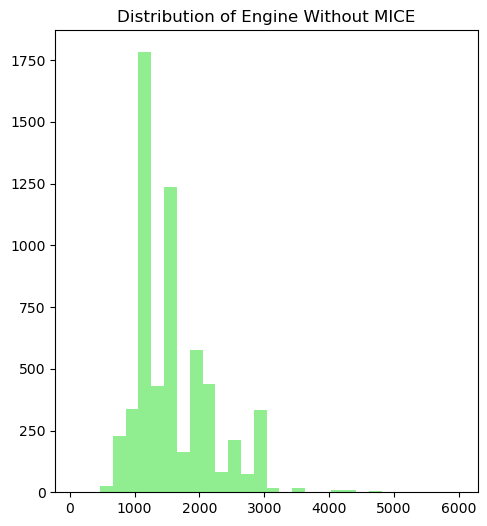

In [93]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(df1['Engine'], bins=30, color='lightgreen')
plt.title('Distribution of Engine Without MICE')

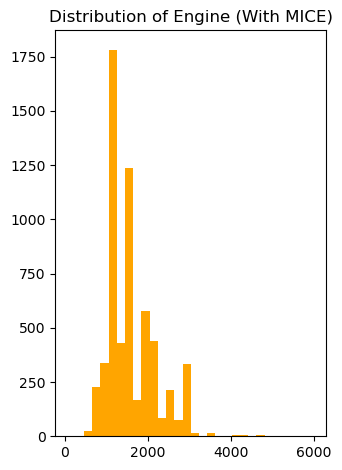

In [94]:
plt.subplot(1, 2, 2)
plt.hist(df2['Engine'], bins=30, color='orange')
plt.title('Distribution of Engine (With MICE)')

plt.tight_layout()
plt.show()

In [95]:
# Section 2

In [96]:
customer = pd.read_csv('lab06_customers.csv')

In [97]:
customer = pd.get_dummies(data=customer, columns=['sex', 'race'], prefix=['sex','race'])
customer["white_male"] = np.multiply(customer["race_white"],customer["sex_male"])
customer["white_female"] = np.multiply(customer["race_white"],customer["sex_female"])
customer["hispanic_male"] = np.multiply(customer["race_hispanic"],customer["sex_male"])
customer["hispanic_female"] = np.multiply(customer["race_hispanic"],customer["sex_female"])
customer["black_male"] = np.multiply(customer["race_black"],customer["sex_male"])
customer["black_female"] = np.multiply(customer["race_black"],customer["sex_female"])
customer["asian_male"] = np.multiply(customer["race_asian"],customer["sex_male"])
customer["asian_female"] = np.multiply(customer["race_asian"],customer["sex_female"])

In [98]:
customer.drop(columns = ['sex_other', 'race_other'], inplace = True)
customer['income']=np.log(customer['income'])
customer.head()

,income,schoolYears,age,spend,sex_female,sex_male,race_asian,race_black,race_hispanic,race_white,white_male,white_female,hispanic_male,hispanic_female,black_male,black_female,asian_male,asian_female
0,11.970135,18.0,31.0,659.97,0,1,0,0,0,1,1,0,0,0,0,0,0,0
1,9.317759,14.0,50.0,719.69,1,0,0,0,0,1,0,1,0,0,0,0,0,0
2,13.227388,14.0,32.0,854.61,0,1,0,0,1,0,0,0,1,0,0,0,0,0
3,12.514979,18.0,52.0,855.20,1,0,0,0,0,1,0,1,0,0,0,0,0,0
4,11.566078,17.0,49.0,758.33,1,0,0,0,0,1,0,1,0,0,0,0,0,0


In [99]:
# 1. Build a linear regression with all the dependent variables and two way interactions between sex and race, 
# consider the other category for race and sex to be the reference category and treat it appropriately

In [105]:
X_interaction = customer.drop('spend', axis=1)
y_interaction = customer['spend']


X_train_interaction, X_test_interaction, y_train_interaction, y_test_interaction = train_test_split(X_interaction, y_interaction, test_size=0.2, random_state=42)


lr_interaction = LinearRegression()
lr_interaction.fit(X_train_interaction, y_train_interaction)


lr_interaction_preds = lr_interaction.predict(X_test_interaction)


lr_interaction_rmse = mean_squared_error(y_test_interaction, lr_interaction_preds, squared=False)

lr_interaction_rmse

42.32488959225484

In [106]:
# 2. Build ridge models with various values for alpha. Create a chart showing how the coefficients change with alpha values

In [107]:
alphas = np.logspace(-4, 4, 100)
coefficients = []

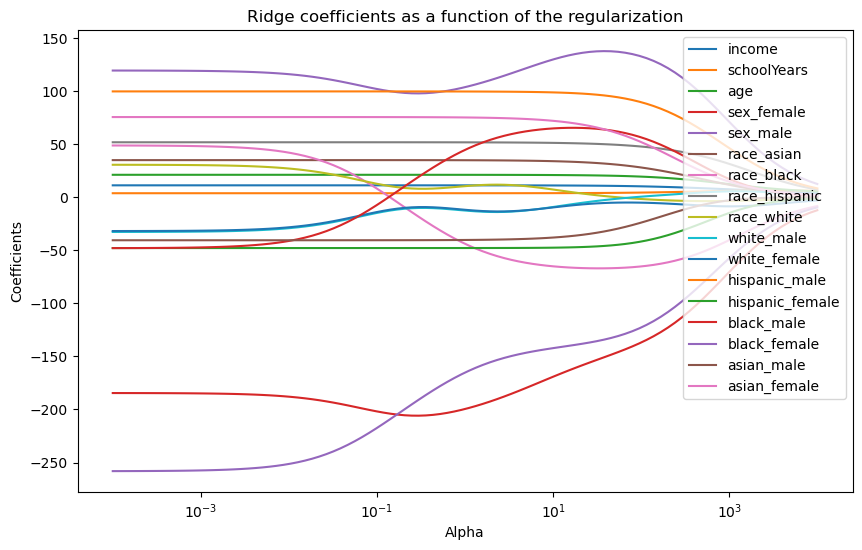

In [108]:
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_interaction, y_train_interaction)
    coefficients.append(ridge.coef_)

feature_names = X_train_interaction.columns

plt.figure(figsize=(10, 6))
ax = plt.gca()
ax.plot(alphas, coefficients)
ax.set_xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.title('Ridge coefficients as a function of the regularization')
plt.legend(feature_names, loc='upper right')
plt.axis('tight')
plt.show()

In [ ]:
# 3. Build lasso models with various values for alpha. Create a chart showing how the coefficients
# change with alpha values

In [ ]:
coefficients_lasso = []

for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train_interaction, y_train_interaction)
    coefficients_lasso.append(lasso.coef_)

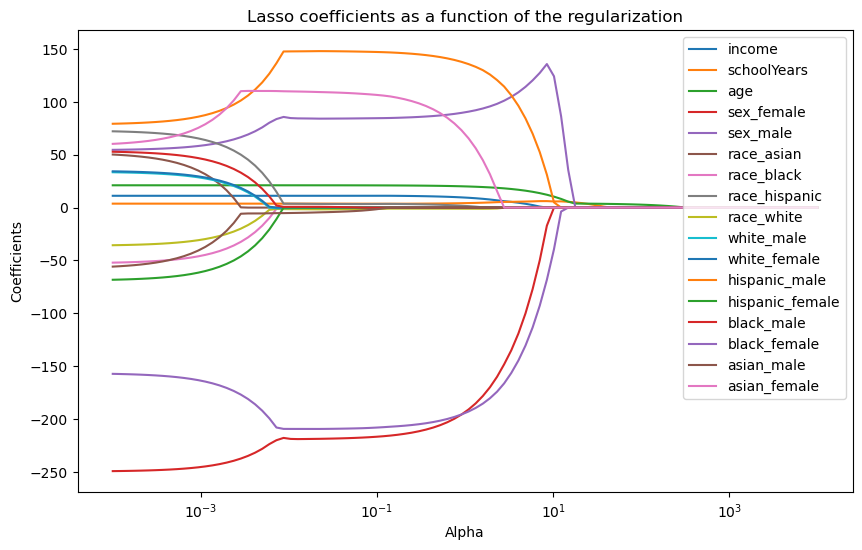

In [110]:
plt.figure(figsize=(10, 6))
ax = plt.gca()
ax.plot(alphas, coefficients_lasso)
ax.set_xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.title('Lasso coefficients as a function of the regularization')
plt.legend(feature_names, loc='upper right')
plt.axis('tight')
plt.show()

In [ ]:
# 4. Compare the coefficients from linear regression, ridge, and lasso (select an alpha value using your chat)

In [111]:
lr_coefs = lr_interaction.coef_

ridge_alpha1 = Ridge(alpha=1)
lasso_alpha1 = Lasso(alpha=1)
ridge_alpha1.fit(X_train_interaction, y_train_interaction)
lasso_alpha1.fit(X_train_interaction, y_train_interaction)

Lasso(alpha=1)

In [112]:
ridge_coefs = ridge_alpha1.coef_
lasso_coefs = lasso_alpha1.coef_

coef_df = pd.DataFrame({'Feature': feature_names, 'Linear Regression': lr_coefs, 'Ridge': ridge_coefs, 'Lasso': lasso_coefs})
coef_df

,Feature,Linear Regression,Ridge,Lasso
0,income,11.175474,11.164829,9.486583
1,schoolYears,3.737435,3.741175,4.225697
2,age,21.100589,21.069850,20.062694
3,sex_female,-184.473373,-199.522380,-193.413853
4,sex_male,119.355345,103.669975,90.141713
5,race_asian,34.923563,34.821960,0.000000
6,race_black,48.780959,-43.894470,-0.000000
7,race_hispanic,51.745705,51.680221,1.594914
8,race_white,30.584202,10.393868,-1.042490
9,white_male,-32.782776,-12.567438,-0.000000


In [113]:
# 5. Compare the R2 from lr, ridge, and lasso

In [116]:
lr_r2 = r2_score(y_test_interaction, lr_interaction_preds)

ridge_preds = ridge_alpha1.predict(X_test_interaction)
lasso_preds = lasso_alpha1.predict(X_test_interaction)

ridge_r2 = r2_score(y_test_interaction, ridge_preds)
lasso_r2 = r2_score(y_test_interaction, lasso_preds)

lr_r2, ridge_r2, lasso_r2

(0.8664687546579961, 0.8665101957015858, 0.8616542758917287)

In [117]:
# 6. Which model would you choose, and why?

In [118]:
# I would choose the Ridge model. The Ridge model has the highest R-squared score among the three models, 
# indicating that it explains the variance in the data better than the other two models.

In [ ]:
# 7. Which variables are dropped from the chosen model that were not dropped in linear regression?

In [ ]:
# All features from the Linear Regression model were also included in the Ridge model.
# This is because Ridge regression does not typically set coefficients to zero unless the alpha parameter is extremely large. 
# Instead, it tends to shrink the coefficients of less important features closer to zero.